# 1. STRUPHY

In [1]:
import time
start_simulation = time.time()

import os

import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp

import hylife.utilitis_FEEC.bsplines              as bsp
import hylife.utilitis_FEEC.projectors_global_mhd as mhd
import hylife.utilitis_FEEC.projectors_global     as proj
import hylife.utilitis_FEEC.derivatives           as der
import hylife.utilitis_FEEC.evaluation            as eva
import hylife.utilitis_FEEC.mass_matrices         as mass

import hylife.geometry.mappings_old               as maps

import hylife.utilitis_PIC.STRUPHY_fields         as pic_fields
import hylife.utilitis_PIC.STRUPHY_pusher         as pic_pusher
import hylife.utilitis_PIC.STRUPHY_accumulation   as pic_accumu
import hylife.utilitis_PIC.STRUPHY_sampling       as pic_sample
import hylife.utilitis_PIC.sobol_seq              as sobol


In [2]:
# ========================================== parameters ==============================================================
Nel       = [16, 3, 3]                # mesh generation on logical domain
bc        = [True, True, True]        # boundary conditions (True: periodic, False: else)
p         = [3, 2, 2]                 # spline degrees  
L         = [2*np.pi/0.75, 1., 1.]    # box lengthes of physical domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
Nbase0    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
Nbase_old = [Nel + p for Nel, p, bc in zip(Nel, p, bc)]                        # TODO delete this later
Ntot      =  Nbase0[0]*Nbase0[1]*Nbase0[2]                                     # total number of basis functions


time_int  = True     # do time integration?
dt        = 0.06     # time step
Tend      = 0.8      # simulation time
max_time  = 60*60    # maximum runtime of program in minutes


# geometry (slab geometry)
DF        = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])           # Jacobian matrix
DFinv     = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])           # inverse Jacobian matrix

G         = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])  # metric tensor
Ginv      = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])  # inverse metric tensor

g_sqrt    = L[0]*L[1]*L[2]                                                             # Jacobian determinant

mapping   = maps.mappings(['slab', L[0], L[1], L[2]])                                  # object for mappings in MHD part


# particle parameters
Np        = 10048              # total number of particles
vth       = 1.                  # thermal velocity of particles in all directions

v0x       = 2.5                 # mean velocity of hot ions in x-direction (must be compatible with backgound field)
v0y       = 0.                  # mean velocity of hot ions in y-direction (must be compatible with backgound field)
v0z       = 0.                  # mean velocity of hot ions in z-direction (must be compatible with backgound field)

nuh       = 0.05                # ratio of hot/bulk equlibrium number densities 

control   = 1                   # control variate? (0: no, 1: yes)

# particle loading
loading   = 'pr_space_uni_velocity'  # 'pseudo-random': particles[:, :6] = np.random.rand(Np, 6)
                                # 'sobol_standard': particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000)
                                # 'sobol_antithetic': sobol.i4_sobol_generate(6, int(Np/64), 1000) --> 64 symmetric particles
                                # 'pr_space_uni_velocity': pseudo-random in space, uniform in velocity space
                                # 'external': particles[:, :6] = np.load('name_of_file.npy')
            
        
add_pressure = False             # add pressure terms to simulation?
                           
            
            
# name and directory of output data file
#identifier  = 'STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x_sobol_ref'
identifier  = 'STRUPHY_test'
dir_results = 'results/'



# Is this run a restart? If True, locate restart files
restart = False  

name_particles = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=particles1.npy'
name_rho_coeff = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=rho_coeff1.npy'
name_u_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=u_coeff1.npy'
name_b_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=b_coeff1.npy'
name_p_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=p_coeff1.npy'
name_control   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=CV1.npy'
name_time_step = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=time1.npy'


# Create restart files at the end of the simulation? If True, name full directory where to save them
create_restart = False
dir_restart    = '/home/florian/Desktop/PHD/02_Projekte/hylife/restart_files/' + identifier + '_restart_files/'
# =====================================================================================================================



# ===================== coefficients for pp-forms in interval [0, delta] (N and D) ====================================
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
# =====================================================================================================================




# ====================================== background quantities ========================================================
Ueq_phys   = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq        = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys   = np.array([1., 0., 0.])     # background magnetic field (vector/2-form on physical domain)
Beq        = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)

B0_23      = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (1.)
B0_31      = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0.)   
B0_12      = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (0.)   

B0_hat     = [B0_23, B0_31, B0_12]

rhoeq_phys = 1.                         # background bulk mass density (scalar/3-from on physical domain)
peq_phys   = 1.                         # background bulk pressure (scalar/0-form on physical domain)


rho0_123   = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * (rhoeq_phys) # background bulk mass density (3-form on logical domain)
peq        = lambda q1, q2, q3 : np.ones(q1.shape) * (peq_phys)            # background bulk pressure (0-form on logical domain)

gamma      = 5/3                        # adiabatic exponent
# =====================================================================================================================



# ============================================== initial conditions ===================================================
kx     = 0.75  # wavenumber of initial perturbation in x - direction
ky     = 0.    # wavenumber of initial perturbation in y - direction
kz     = 0.    # wavenumber of initial perturbation in z - direction

amp    = 1e-3  # amplitude  of initial perturbation

B1_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (0. * q1)
B2_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0. * q1)
B3_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (amp * np.sin(kx * q1 * L[0] + ky * q2 * L[1]))

U1_ini = lambda q1, q2, q3 : mapping.DF[0][0](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U2_ini = lambda q1, q2, q3 : mapping.DF[1][1](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U3_ini = lambda q1, q2, q3 : mapping.DF[2][2](q1, q2, q3) * (0. * q1)  # actually DF.T !!


'''
Nmodes = 128
modes  = np.linspace(0, Nmodes, Nmodes + 1) - Nmodes/2
modes  = np.delete(modes, int(Nmodes/2))
amps   = np.random.rand(8, Nmodes)



def U1_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[0, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values

def U2_ini(q1, q2, q3):
    
    values = np.zeros(q2.shape)
    
    for i in range(Nmodes):
        values += amps[1, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values

def U3_ini(q1, q2, q3):
    
    values = np.zeros(q3.shape)
    
    for i in range(Nmodes):
        values += amps[2, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values


def B1_ini(q1, q2, q3):
    
    values = np.zeros(q2.shape)
    
    for i in range(Nmodes):
        values += 0*np.sin(2*np.pi*modes[i]*q1)
        
    return values

def B2_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[4, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values

def B3_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[5, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values


def rho_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[6, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values


def p_ini(q1, q2, q3):
    
    values = 0.
    
    for i in range(Nmodes):
        values += amps[7, i]*np.sin(2*np.pi*modes[i]*q1)
        
    return values
'''



nh0_phys = rhoeq_phys*nuh                                    # hot ion number density on physical domain
nh0_123  = nh0_phys*g_sqrt                                   # hot ion number density on logical domain
Eh_eq    = nh0_123/2*(v0x**2 + v0y**2 + v0z**2 + 3*vth**2/2) # hot ion equilibrium energy

# initial hot ion distribution function (3-form on logical domain)
fh0             = lambda q1, q2, q3, vx, vy, vz : nh0_123/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# control variate
control_variate = lambda q1, q2, q3, vx, vy, vz : nh0_123/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# initial sampling distribution
g_sampling      = lambda q1, q2, q3, vx, vy, vz :       1/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)
# =====================================================================================================================

In [3]:
# ========================================= reserve memory for unknowns ===============================================
rho   = np.empty(1*Ntot, dtype=float)   # density  FEM coefficients

u     = np.empty(3*Ntot, dtype=float)   # U-field  FEM coefficients
u_old = np.empty(3*Ntot, dtype=float)   # U-field  FEM coefficients from previous time step (needed in integration step 3)

b     = np.empty(3*Ntot, dtype=float)   # B-field  FEM coefficients

pr    = np.empty(1*Ntot, dtype=float)   # pressure FEM coefficients


# matrices and vectors in steps 1 and 3
mat11 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat12 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat13 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

mat22 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat23 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat33 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

vec1  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec2  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec3  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

# particles and knot span indices
particles = np.empty((Np, 7), dtype=float, order='F')
spans0    = np.empty((Np, 3), dtype=int,   order='F')

# fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

# energies (bulk kinetic energy, magnetic energy, bulk internal energy, hot ion kinetic + internal energy (delta f))
energies = np.empty(4, dtype=float)
# =====================================================================================================================

projection of initial conditions done!


Text(0,0.5,'$p$')

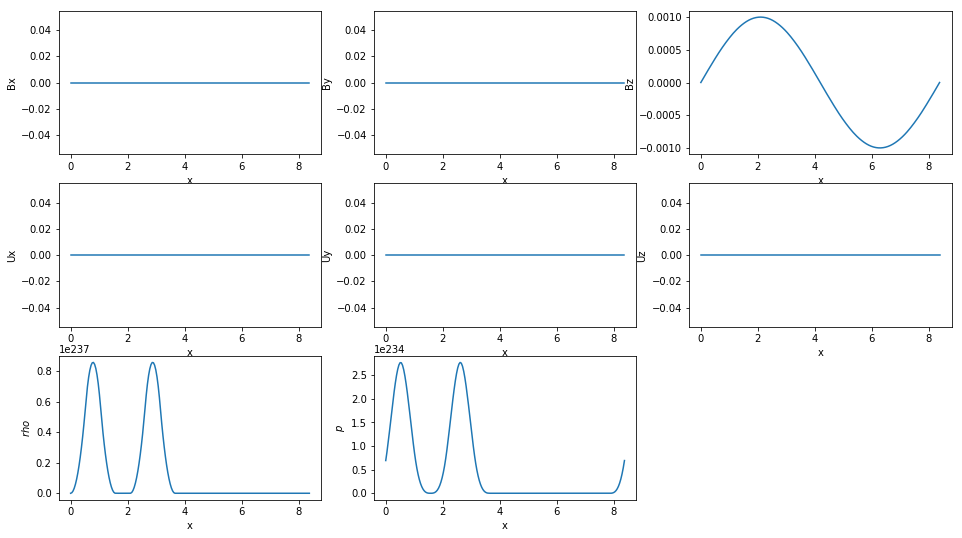

In [4]:
# ======================================== projection of initial conditions ===========================================
# create object for projecting initial conditions
PRO = proj.projectors_3d(T, p, bc)

# left-hand sides of projectors
PRO.assemble_V0()
PRO.assemble_V1()
PRO.assemble_V2()
PRO.assemble_V3()

# projection of initial conditions
#rho[:]             = PRO.PI_3(rho_ini)

temp1, temp2, temp3 = PRO.PI_1([U1_ini, U2_ini, U3_ini])
u[0*Ntot:1*Ntot]    = temp1.flatten()
u[1*Ntot:2*Ntot]    = temp2.flatten() 
u[2*Ntot:3*Ntot]    = temp3.flatten()

temp1, temp2, temp3 = PRO.PI_2([B1_ini, B2_ini, B3_ini])
b[0*Ntot:1*Ntot]    = temp1.flatten()     
b[1*Ntot:2*Ntot]    = temp2.flatten() 
b[2*Ntot:3*Ntot]    = temp3.flatten()

#pr[:]              = PRO.PI_0(p_ini)

del temp1, temp2, temp3

print('projection of initial conditions done!')
# =====================================================================================================================


# plot initial conditions on physical domain
q1plot = np.linspace(0., 1., 200)
q2plot = np.array([0.5])
q3plot = np.array([0.5])

rhoini              = eva.FEM_field_V3_3d(rho, [q1plot, q2plot, q3plot], T, p, bc)
Bini1, Bini2, Bini3 = eva.FEM_field_V2_3d([b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)
Uini1, Uini2, Uini3 = eva.FEM_field_V1_3d([u[0*Ntot:1*Ntot], u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)
pini                = eva.FEM_field_V0_3d(rho, [q1plot, q2plot, q3plot], T, p, bc)


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(9)

plt.subplot(3, 3, 1)
plt.plot(q1plot*L[0], 1/g_sqrt*DF[0, 0]*Bini1[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bx')

plt.subplot(3, 3, 2)
plt.plot(q1plot*L[0], 1/g_sqrt*DF[1, 1]*Bini2[:, 0, 0])
plt.xlabel('x')
plt.ylabel('By')

plt.subplot(3, 3, 3)
plt.plot(q1plot*L[0], 1/g_sqrt*DF[2, 2]*Bini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bz')

plt.subplot(3, 3, 4)
plt.plot(q1plot*L[0], DFinv[0, 0]*Uini1[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Ux')

plt.subplot(3, 3, 5)
plt.plot(q1plot*L[0], DFinv[1, 1]*Uini2[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uy')

plt.subplot(3, 3, 6)
plt.plot(q1plot*L[0], DFinv[2, 2]*Uini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uz')

plt.subplot(3, 3, 7)
plt.plot(q1plot*L[0], rhoini[:, 0, 0]/g_sqrt)
plt.xlabel('x')
plt.ylabel('$rho$')

plt.subplot(3, 3, 8)
plt.plot(q1plot*L[0], pini[:, 0, 0])
plt.xlabel('x')
plt.ylabel('$p$')

In [5]:
# ============================================ MHD matrices ===========================================================
# create object for projecting MHD matrices
MHD = mhd.projections_mhd(p, Nbase_old, T, bc)

# right-hand side of projection matrices
Q1,   Q2,   Q3   = MHD.projection_Q(rho0_123, mapping.Ginv)
W1,   W2,   W3   = MHD.projection_W(rho0_123, mapping.g_sqrt)
TAU1, TAU2, TAU3 = MHD.projection_T(B0_hat, mapping.Ginv)
S1,   S2,   S3   = MHD.projection_S(peq)
K                = MHD.projection_K(peq)

# mass matrices in V0, V1 and V2
M0 = mass.mass_V0_3d(T, p, bc, mapping.g_sqrt)
M1 = mass.mass_V1_3d(T, p, bc, [mapping.g_sqrt, mapping.Ginv])
M2 = mass.mass_V2_3d(T, p, bc, [mapping.g_sqrt, mapping.G])

# normalization vector in V0
norm = mass.inner_prod_V0_3d(T, p, bc, lambda q1, q2, q3 : np.ones(q1.shape), mapping.g_sqrt).flatten()

# discrete grad, curl and div matrices
derivatives = der.discrete_derivatives(T, p, bc)

GRAD = derivatives.GRAD_3d()
CURL = derivatives.CURL_3d()
DIV  = derivatives.DIV_3d()

# Perform projections of Q
Q1   = sparse.linalg.spsolve(PRO.interhistopolation_V2[0], Q1)
Q2   = sparse.linalg.spsolve(PRO.interhistopolation_V2[1], Q2)
Q3   = sparse.linalg.spsolve(PRO.interhistopolation_V2[2], Q3)

Q    = sparse.bmat([[Q1], [Q2], [Q3]], format='csc')

del Q1, Q2, Q3

# perform projections of W1, W2, W3
W1   = sparse.linalg.spsolve(PRO.interhistopolation_V1[0], W1)
W2   = sparse.linalg.spsolve(PRO.interhistopolation_V1[1], W2)
W3   = sparse.linalg.spsolve(PRO.interhistopolation_V1[2], W3)

W    = sparse.bmat([[W1, None, None], [None, W2, None], [None, None, W3]], format='csc')

del W1, W2, W3

# perform projections of TAU1, TAU2, TAU3
TAU1 = sparse.linalg.spsolve(PRO.interhistopolation_V1[0], TAU1)
TAU2 = sparse.linalg.spsolve(PRO.interhistopolation_V1[1], TAU2)
TAU3 = sparse.linalg.spsolve(PRO.interhistopolation_V1[2], TAU3)

TAU  = sparse.bmat([[TAU1], [TAU2], [TAU3]], format='csc')

del TAU1, TAU2, TAU3

# perform projections of S1, S2, S3
S1   = sparse.linalg.spsolve(PRO.interhistopolation_V1[0], S1)
S2   = sparse.linalg.spsolve(PRO.interhistopolation_V1[1], S2)
S3   = sparse.linalg.spsolve(PRO.interhistopolation_V1[2], S3)

S    = sparse.bmat([[S1, None, None], [None, S2, None], [None, None, S3]], format='csc')

del S1, S2, S3

# perform projection of K
K   = sparse.linalg.spsolve(PRO.interhistopolation_V0, K).tocsc()

# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1))

del W


# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step 2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

# matrices for non-Hamiltonian part
MAT = GRAD.T.dot(M1).dot(S) + (gamma - 1)*K.T.dot(GRAD.T).dot(M1)

del S, K

LHS_LU = sparse.linalg.splu((sparse.bmat([[sparse.identity(Ntot),  dt/2*DIV.dot(Q), None], [None, A,  dt/2*M1.dot(GRAD)], [None, -dt/2*MAT, M0]])).tocsc())
RHS    =                     sparse.bmat([[sparse.identity(Ntot), -dt/2*DIV.dot(Q), None], [None, A, -dt/2*M1.dot(GRAD)], [None,  dt/2*MAT, M0]], format='csc')

A = A.toarray()

# delete everything which is not needed to save memory
del PRO, MHD, M0, GRAD, DIV, Q, MAT

print('assembly of constant matrices done!')
# ======================================================================================================================

assembly of constant matrices done!


Text(0,0.5,'$n_{h0}(U x B)_z$')

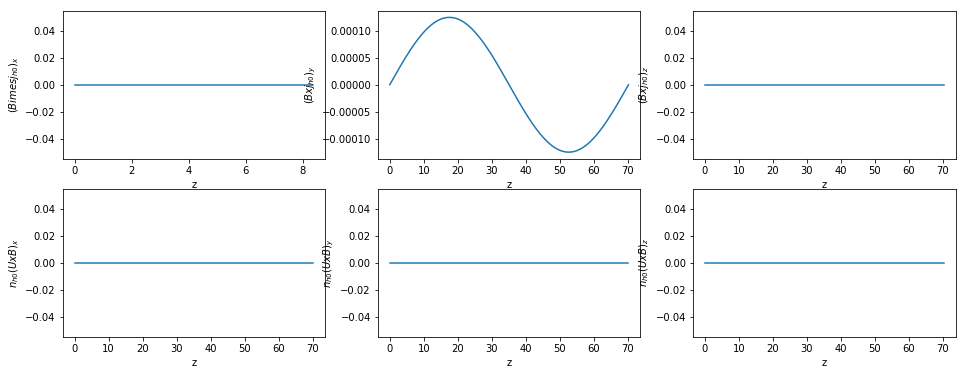

In [6]:
# check initial control variates
J14_control       = mass.inner_prod_V1_jh0(T, p, bc, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], [nh0_phys*v0x, nh0_phys*v0y, nh0_phys*v0z], Beq, DFinv, [mapping.g_sqrt, mapping.Ginv])
J11_control       = mass.mass_V1_nh0(T, p, bc, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], nh0_123, Beq, mapping.Ginv)

J14_control_coeff = sparse.linalg.spsolve(M1, np.concatenate((J14_control[0].flatten(), J14_control[1].flatten(), J14_control[2].flatten())))
J11_control_coeff = sparse.linalg.spsolve(M1, -J11_control.dot(u))


J14_control_1, J14_control_2, J14_control_3 = eva.FEM_field_V1_3d([J14_control_coeff[0*Ntot:1*Ntot], J14_control_coeff[1*Ntot:2*Ntot], J14_control_coeff[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)
J11_control_1, J11_control_2, J11_control_3 = eva.FEM_field_V1_3d([J11_control_coeff[0*Ntot:1*Ntot], J11_control_coeff[1*Ntot:2*Ntot], J11_control_coeff[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(q1plot*L[0], DFinv[0, 0]*J14_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B \times j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(q1plot*L[0]*L[0], DFinv[1, 1]*J14_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(q1plot*L[0]*L[0], DFinv[2, 2]*J14_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(q1plot*L[0]*L[0], DFinv[0, 0]*J11_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(q1plot*L[0]*L[0], DFinv[1, 1]*J11_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(q1plot*L[0]*L[0], DFinv[2, 2]*J11_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

In [7]:
# ================================================ create particles ====================================================
if   loading == 'pseudo-random':
    # pseudo-random numbers between (0, 1)
    particles[:, :6] = np.random.rand(Np, 6)
    
elif loading == 'sobol_standard':
    # plain sobol numbers between (0, 1) (skip first 1000 numbers)
    particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000) 
    
elif loading == 'sobol_antithetic':
    # symmetric sobol numbers between (0, 1) (skip first 1000 numbers) in all 6 dimensions
    pic_sample.set_particles_symmetric(sobol.i4_sobol_generate(6, int(Np/64), 1000), particles)  
    
elif loading == 'pr_space_uni_velocity':
    # pseudo-random numbers in space and uniform in velocity space
    particles[:, :3] = np.random.rand(Np, 3)
    
    dv = 1/Np
    particles[:,  3] = np.linspace(dv, 1 - dv, Np)
    particles[:,  4] = np.linspace(dv, 1 - dv, Np)
    particles[:,  5] = np.linspace(dv, 1 - dv, Np)
    
elif loading == 'external':
    # load numbers between (0, 1) from an external file
    particles[:, :6] = np.load('test_particles.npy')
    
else:
    print('particle loading not specified')

# inversion of cumulative distribution function
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth + v0x
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth + v0y
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0z

# compute parameters for control variate and initial weights
g0 = g_sampling(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0

particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 

# compute initial knot span indices
spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]

print('particle initialization done!')
# =====================================================================================================================

particle initialization done!


(array([0.000e+00, 1.000e+00, 2.000e+00, 7.000e+00, 1.700e+01, 3.700e+01,
        7.700e+01, 1.460e+02, 2.530e+02, 4.040e+02, 5.920e+02, 7.970e+02,
        9.860e+02, 1.121e+03, 1.168e+03, 1.121e+03, 9.860e+02, 7.970e+02,
        5.920e+02, 4.040e+02, 2.530e+02, 1.460e+02, 7.700e+01, 3.700e+01,
        1.700e+01, 7.000e+00, 2.000e+00, 1.000e+00, 0.000e+00]),
 array([-3.        , -2.79310345, -2.5862069 , -2.37931034, -2.17241379,
        -1.96551724, -1.75862069, -1.55172414, -1.34482759, -1.13793103,
        -0.93103448, -0.72413793, -0.51724138, -0.31034483, -0.10344828,
         0.10344828,  0.31034483,  0.51724138,  0.72413793,  0.93103448,
         1.13793103,  1.34482759,  1.55172414,  1.75862069,  1.96551724,
         2.17241379,  2.37931034,  2.5862069 ,  2.79310345,  3.        ]),
 <a list of 29 Patch objects>)

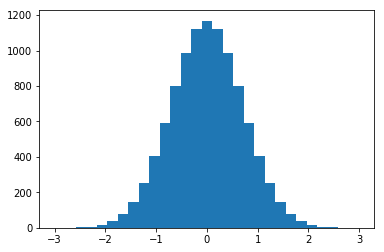

In [8]:
#plt.hist(particles[:, 0], bins = np.linspace(0., 1., 30))
#plt.hist(particles[:, 3], bins = np.linspace(-3., 3., 30) + v0x)
#plt.hist(particles[:, 4], bins = np.linspace(-3., 3., 30) + v0y)
plt.hist(particles[:, 4], bins = np.linspace(-3., 3., 30) + v0z)

In [9]:
# ================ compute initial fields at particle positions and initial energies ==================================
timea = time.time()
pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(u[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
timeb = time.time()
print('initial field computation at particles done. Time : ', timeb-timea)


# initial energies
energies[0] = 1/2*u.dot(A.dot(u))
energies[1] = 1/2*b.dot(M2.dot(b))
energies[2] = 1/(gamma - 1)*pr.dot(norm)
energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*Eh_eq
# =====================================================================================================================

initial field computation at particles done. Time :  0.19877171516418457


In [14]:
pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)

test_coeff = sparse.linalg.spsolve(M1, np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np)

test_1, test_2, test_3 = eva.FEM_field_V1_3d([test_coeff[0*Ntot:1*Ntot], test_coeff[1*Ntot:2*Ntot], test_coeff[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)

Text(0,0.5,'$(Bx j_{h})_z$')

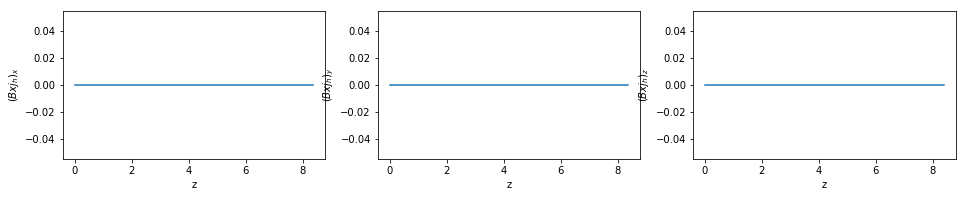

In [15]:
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)


plt.subplot(2, 3, 1)
plt.plot(q1plot*L[0], DFinv[0, 0]*test_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h})_x$')

plt.subplot(2, 3, 2)
plt.plot(q1plot*L[0], DFinv[1, 1]*test_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h})_y$')

plt.subplot(2, 3, 3)
plt.plot(q1plot*L[0], DFinv[2, 2]*test_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h})_z$')

In [16]:
# =============================================== time integrator =====================================================
def update():
    
    # step 1 (update u)
    pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)
    
    AJ11A = -np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [-mat12.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot)], [-mat13.reshape(Ntot, Ntot).T, -mat23.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot))]])/Np
    
    if control == 1:
        AJ11A -= mass.mass_V1_nh0(T, p, bc, mapping.Ginv, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, nh0_123).toarray()
    
    u[:] = np.linalg.solve(A - dt/2*AJ11A, (A + dt/2*AJ11A).dot(u))
    
    
    # step 2 (update first u, then b and evaluate B-field at particle positions)
    u_old[:] = u
    
    u[:] = STEP2_schur_LU.solve(STEP2_1.dot(u_old) + STEP2_2.dot(b))
    b[:] = b - dt/2*CURL.dot(TAU.dot(u_old + u))
    
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    
    
    # step 3 (update first u, then evaluate U-field at particle positions and then update V)
    pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)
    
    BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot).T, mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot).T, mat23.reshape(Ntot, Ntot).T, mat33.reshape(Ntot, Ntot)]])/Np
    
    u_old[:] = u
    
    if control == 1:
        CV = mass.inner_prod_V1_jh0(T, p, bc, mapping.Ginv, mapping.DFinv, mapping.g_sqrt, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, [nh0_phys*v0x, nh0_phys*v0y, nh0_phys*v0z])
        
        u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np + dt*np.concatenate((CV[0].flatten(), CV[1].flatten(), CV[2].flatten())))
    
    
    else:
        u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np)
    
    
    pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(1/2*(u + u_old)[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
    
    pic_pusher.pusher_step3(particles, L, dt, B_part, U_part)
    
    # step 4 (update Q and spans)
    pic_pusher.pusher_step4(particles, L, dt)
    
    spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
    spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
    spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
    
    # step 5 (update V and weights)
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    pic_pusher.pusher_step5(particles, L, dt, B_part)
    
    particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 
    
    # step 6 (non-Hamiltonian)
    if add_pressure:
        rho[:], u[:], pr[:] = np.split(LHS_LU.solve(RHS.dot(np.concatenate((rho, u, pr)))), [Ntot, 4*Ntot])
    
    # diagnostics (compute energies)
    energies[0] = 1/2*u.dot(A.dot(u))
    energies[1] = 1/2*b.dot(M2.dot(b))
    energies[2] = 1/(gamma - 1)*pr.dot(norm)
    energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*Eh_eq
# =====================================================================================================================    

In [50]:
# ========================================== time integration =========================================================
if time_int == True:
    
    if restart == False:
        title = dir_results + identifier + '.txt'
        file  = open(title, 'ab')
        
        
        # == initial data to save ==
        data  = np.concatenate((energies, np.array([0.])))
        np.savetxt(file, data.reshape(1, 5), fmt = '%1.16e')
        
        #data  = np.concatenate((pr, u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot], energies, np.array([0.])))
        #np.savetxt(file, data.reshape(1, len(pr) + len(u[1*Ntot:2*Ntot]) + len(u[2*Ntot:3*Ntot]) + 5), fmt = '%1.16e')
        # ==========================

        print('initial energies : ', energies)
        
        time_step = 0
        counter   = 0
        
    else:
        title = dir_results + identifier + '.txt'
        file  = open(title, 'ab')
        
        particles[:, :]    = np.load(name_particles)
        rho[:]             = np.load(name_rho_coeff)
        u[:]               = np.load(name_u_coeff)
        b[:]               = np.load(name_b_coeff)
        pr[:]              = np.load(name_p_coeff)
        w0                 = np.load(name_control)[0]
        g0                 = np.load(name_control)[1]
        time_step, counter = np.load(name_time_step)
        
        spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
        spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
        spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
        
        pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
        pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(u[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
        
        particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 

        
    print('start time integration! (total number of time steps : ' + str(int(Tend/dt)) + ')')
    
    while True:

        if (time_step*dt >= Tend) or ((time.time() - start_simulation)/60 > max_time):
            
            if create_restart:
                
                if not os.path.exists(dir_restart):
                    os.makedirs(dir_restart)
                
                counter += 1

                np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                np.save(dir_restart + identifier + '_restart=rho_coeff' + str(counter), rho)
                np.save(dir_restart + identifier + '_restart=u_coeff'   + str(counter), u)
                np.save(dir_restart + identifier + '_restart=b_coeff'   + str(counter), b)
                np.save(dir_restart + identifier + '_restart=p_coeff'   + str(counter), pr)
                np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))
            
            break

        if time_step%10 == 0:
            print('time steps finished : ' + str(time_step))
            print('energies : ', energies)

        timea = time.time()
        update()
        timeb = time.time()

        if time_step == 0:
            print('time for one time step : ', timeb-timea)

        # == data to save ==========
        data  = np.concatenate((energies, np.array([(time_step + 1)*dt])))
        np.savetxt(file, data.reshape(1, 5), fmt = '%1.16e')
        
        #data  = np.concatenate((pr, u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot], energies, np.array([(time_step + 1)*dt])))
        #np.savetxt(file, data.reshape(1, len(pr) + len(u[1*Ntot:2*Ntot]) + len(u[2*Ntot:3*Ntot]) + 5), fmt = '%1.16e')
        # ==========================

        time_step += 1

    file.close()
# =====================================================================================================================

initial energies :  [ 1.  0. -3.  3.]
start time integration! (total number of time steps : 400)
time steps finished : 0
energies :  [ 1.  0. -3.  3.]
time for one time step :  0.09129166603088379
time steps finished : 10
energies :  [5.73718987e+01 5.13525735e+01 2.48384646e-13 0.00000000e+00]
time steps finished : 20
energies :  [ 5.88486660e+01  5.13244438e+01 -1.06081810e-13  0.00000000e+00]
time steps finished : 30
energies :  [ 6.22510354e+01  4.80653212e+01 -4.80115947e-13  0.00000000e+00]
time steps finished : 40
energies :  [ 6.94507974e+01  4.28230372e+01 -4.77576312e-13  0.00000000e+00]
time steps finished : 50
energies :  [5.74574519e+01 5.35803287e+01 2.67402767e-12 0.00000000e+00]
time steps finished : 60
energies :  [6.08453466e+01 4.96446250e+01 3.28279071e-12 0.00000000e+00]
time steps finished : 70
energies :  [6.19129958e+01 4.96553777e+01 3.52035068e-12 0.00000000e+00]
time steps finished : 80
energies :  [6.26911919e+01 4.98786470e+01 3.12400106e-12 0.00000000e+00]

In [56]:
# Newton method for step 4
import numpy as np

A      = np.empty((3, 3), dtype=float)
A_next = np.empty((3, 3), dtype=float)

v      = np.array([0.5, 0.0, 0.0])
q      = np.array([0.2, 0.499, 0.])
dt     = 0.1
#params = [1., 1.]
params = [1., 1., 1.]

#==========================================================================================================
def mapping_matrices(q, kind, params, output, A):
    
    A[:, :] = 0.
    
    # kind = 1 : slab geometry (params = [Lx, Ly, Lz], output = [DF, DF_inv, G, Ginv])
    if kind == 1:
    
        Lx = params[0]
        Ly = params[1]
        Lz = params[2]
        
        if output == 1:

            A[0, 0] = Lx
            A[1, 1] = Ly
            A[2, 2] = Lz
            
        elif output == 2:
            
            A[0, 0] = 1/Lx
            A[1, 1] = 1/Ly
            A[2, 2] = 1/Lz
            
        elif output == 3:
            
            A[0, 0] = Lx**2
            A[1, 1] = Ly**2
            A[2, 2] = Lz**2
            
        elif output == 4:
            
            A[0, 0] = 1/Lx**2
            A[1, 1] = 1/Ly**2
            A[2, 2] = 1/Lz**2
            
    # kind = 2 : cylinder (params = [R, Lz], output = [DF, DF_inv, G, Ginv])
    elif kind == 2:
        
        R = params[0]
        L = params[1]
        
        if output == 1:
            
            A[0, 0] =       np.cos(2*np.pi*q[1])
            A[0, 1] = -q[1]*np.sin(2*np.pi*q[1])*2*np.pi
            A[1, 0] =       np.sin(2*np.pi*q[1])
            A[1, 1] =  q[1]*np.cos(2*np.pi*q[1])*2*np.pi
            A[2, 2] =  1.
            
        elif output == 2:
            
            A[0, 0] =   np.cos(2*np.pi*q[1])
            A[0, 1] =   np.sin(2*np.pi*q[1])
            A[1, 0] =  -np.sin(2*np.pi*q[1])/(2*np.pi*q[0])
            A[1, 1] =   np.cos(2*np.pi*q[1])/(2*np.pi*q[0])
            A[2, 2] =  1.
            
        elif output == 3:
            
            A[0, 0] = 1.
            A[1, 1] = (2*np.pi*q[0])**2
            A[2, 2] = 1.
            
        elif output == 4:
            
            A[0, 0] = 1.
            A[1, 1] = 1/(2*np.pi*q[0])**2
            A[2, 2] = 1. 
            
    # kind = 3: collela (params = [Lx, Ly, alpha], output = [DF, DF_inv, G, Ginv])
    elif kind == 3:
        
        Lx    = params[0]
        Ly    = params[1]
        alpha = params[2]
        
        q1 = q[0]
        q2 = q[1]

        if output == 1:
            
            A[0, 0] = Lx*(1. + alpha*np.cos(2*np.pi*q1)*np.sin(2*np.pi*q2)*2*np.pi)
            A[0, 1] = Lx*(q1 + alpha*np.sin(2*np.pi*q1)*np.cos(2*np.pi*q2)*2*np.pi)
            A[1, 0] = Ly*(q2 + alpha*np.cos(2*np.pi*q1)*np.sin(2*np.pi*q2)*2*np.pi)
            A[1, 1] = Ly*(1. + alpha*np.sin(2*np.pi*q1)*np.cos(2*np.pi*q2)*2*np.pi)
            A[2, 2] = 1.
            
        elif output == 2:
            
            det_DF = Lx*Ly*(1 - q1*q2 + (1 - q1)*alpha*np.cos(2*np.pi*q1)*np.sin(2*np.pi*q2)*2*np.pi + (1 - q2)*alpha*np.sin(2*np.pi*q1)*np.cos(2*np.pi*q2)*2*np.pi)
            
            A[0, 0] =  Ly*(1. + alpha*np.sin(2*np.pi*q1)*np.cos(2*np.pi*q2)*2*np.pi)/det_DF
            A[0, 1] = -Lx*(q1 + alpha*np.sin(2*np.pi*q1)*np.cos(2*np.pi*q2)*2*np.pi)/det_DF
            A[1, 0] = -Ly*(q2 + alpha*np.cos(2*np.pi*q1)*np.sin(2*np.pi*q2)*2*np.pi)/det_DF
            A[1, 1] =  Lx*(1. + alpha*np.cos(2*np.pi*q1)*np.sin(2*np.pi*q2)*2*np.pi)/det_DF
            A[2, 2] = 1.
            
        
#========================================================================================================== 

#mapping_matrices(q, 3, params, 2, A)
#mapping_matrices(q, 3, params, 1, A_next)

In [77]:
A

array([[ 1.        , -0.01059492,  0.        ],
       [ 0.0025    ,  0.8937456 ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [78]:
A_next.dot(A)

array([[-0.99996051,  0.01661131,  0.        ],
       [-0.00734647, -0.71114526,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [79]:
def f(q_next):
    
    mapping_matrices(q_next, 2, params, 2, A_next)
    mapping_matrices(q     , 2, params, 2, A)
    
    return q_next - q - dt/2*(A + A_next).dot(v)

In [89]:
def push_logical_domain(q_old, v, dt, accuracy):

    q_new    = np.zeros( 3    , dtype=float)
    J        = np.zeros((3, 3), dtype=float)
    ej       = np.zeros( 3    , dtype=float)
    
    q_new[:] = q_old
    
    A_old    = np.empty((3, 3), dtype=float)
    mapping_matrices(q_old, 2, params, 2, A_old)
    
    A_new1  = np.empty((3, 3), dtype=float)
    A_new2  = np.empty((3, 3), dtype=float)
    
    
    # expression to minimize
    F  = np.ones(3, dtype=float)
    dq = 1e-2
    
    while np.any(np.abs(F) > accuracy):
        print('hello')
        
        # assemble jacobian
        for i in range(3):
            for j in range(3):
                
                ej[:] = 0.
                ej[j] = 1.
                
                mapping_matrices(q_new + dq*ej, 2, params, 2, A_new1)
                mapping_matrices(q_new        , 2, params, 2, A_new2)
                
                J[i, j] = (dq*ej - dt/2*(A_new1 - A_new2).dot(v))[i]/dq

                #J[i, j] = (f(q_new + dq*ej)[i] - f(q_new)[i])/dq
                
        deltaq = np.linalg.solve(J, -(q_new - q_old - dt/2*(A_old + A_new2).dot(v)))
        #deltaq = np.linalg.solve(J, -f(q_new))

        q_new += deltaq
        
        mapping_matrices(q_new, 2, params, 2, A_new2)
        F[:] = q_new - q_old - dt/2*(A_old + A_new2).dot(v)
        
    return q_new

In [90]:
test = push_logical_domain(q, v, dt, 1e-12)

hello
hello
hello
hello


In [91]:
q

array([0.2  , 0.499, 0.   ])

In [92]:
test

array([0.15000139, 0.49865001, 0.        ])

In [93]:
np.array([q[0]*np.cos(2*np.pi*q[1]), q[0]*np.sin(2*np.pi*q[1]), q[2]])

array([-0.19999605,  0.00125663,  0.        ])

In [94]:
np.array([q[0]*np.cos(2*np.pi*q[1]), q[0]*np.sin(2*np.pi*q[1]), q[2]]) + dt*v

array([-0.14999605,  0.00125663,  0.        ])

In [95]:
np.array([test[0]*np.cos(2*np.pi*test[1]), test[0]*np.sin(2*np.pi*test[1]), test[2]])

array([-0.149996  ,  0.00127234,  0.        ])

In [2]:
integrand = lambda x : 1/np.sqrt(x)

In [32]:
n_quad = 2000
pts_loc, wts_loc = np.polynomial.legendre.leggauss(n_quad)
pts,     wts     = bsp.quadrature_grid(np.array([0., 1.]), pts_loc, wts_loc)

In [33]:
value = 0.
for q in range(n_quad):
    value += wts[0, q] * integrand(pts[0, q])

In [34]:
value

1.9995647637915914

In [35]:
import scipy.integrate as integrate

In [36]:
integrate.quad(integrand, 0., 1.)

(1.9999999999999984, 5.773159728050814e-15)

In [96]:
from numpy import dot

In [98]:
a, b = np.random.rand(3), np.random.rand(3)

In [100]:
dot(a, b)

0.6890895437427097